In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, LSTM,SimpleRNN,GRU,Flatten
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adamax,Adam
from keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv("weather_prediction_dataset.csv")

In [ ]:
# normalize the data, excluding the "DATE" column
scalarModel = StandardScaler()
df_normalized = pd.DataFrame(scalarModel.fit_transform(df.drop('DATE', axis=1)), columns=df.drop('DATE', axis=1).columns)
df_train = df_normalized[df['DATE'] <= 20071231]
df_test = df_normalized[df['DATE'] > 20071231]
df_test.reset_index(inplace=True, drop=True)

In [ ]:
print(df_train.shape,df_test.shape)

(2922, 164) (732, 164)


In [ ]:
# Correlations among columns
corr_matrix = df_normalized.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

In [ ]:
# Select Features with high correlation ranges >= 0.85 and <=0.85
corr_filtered = corr_matrix[(corr_matrix['TOURS_temp_max'] > 0.85) | (corr_matrix['TOURS_temp_max'] < -0.85)]
features = corr_filtered.index.tolist()
len(features)

30

- Our dataset contains 196 features, which is a significant number. To ensure that our models are not impacted by the high dimensionality of the data, we first normalized the dataset to bring all features to a similar scale.

- Next, we computed the correlation matrix between all features and our target variable to identify the most informative features. We used a threshold of 0.85 to select the features with the highest correlation values. Features with correlation values ranging between 0.85 and -0.85 were considered to have moderate correlation, while features with correlation values below -0.85 were considered to have a strong negative correlation or strong positive correlation. **In our dataset, there were about 30 features with a strong negative or positive correlation.**

In [ ]:
train = df_train[features]
test = df_test[features]
train

,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,DE_BILT_temp_mean,DE_BILT_temp_max,DRESDEN_temp_mean,DRESDEN_temp_max,DUSSELDORF_temp_mean,DUSSELDORF_temp_max,HEATHROW_temp_mean,...,MONTELIMAR_temp_mean,MONTELIMAR_temp_max,MUENCHEN_temp_mean,MUENCHEN_temp_max,PERPIGNAN_temp_mean,PERPIGNAN_temp_max,ROMA_temp_max,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,-1.095641,-0.810098,-1.334474,-0.743714,-0.929103,-1.120574,-1.291422,-1.037909,-1.081528,-0.859720,...,-1.215249,-1.221159,-1.056878,-1.302258,-0.592258,-0.925635,-1.718399,-0.573097,-0.116057,-0.875278
1,-1.001222,-0.644746,-1.231264,-0.549850,-0.845882,-0.929581,-1.070124,-0.694033,-0.952959,-0.699271,...,-0.825979,-1.069226,-1.031568,-0.953252,-0.962857,-0.839601,-1.665941,-0.665886,-0.221478,-0.953060
2,-1.190060,-1.035579,-1.231264,-0.372142,-0.721052,-0.713122,-0.948410,-0.514619,-0.798675,-0.431856,...,-1.535007,-1.221159,-1.322629,-1.487667,-1.148156,-1.040347,-0.000424,-0.634957,-0.221478,-0.901205
3,-0.960756,-0.975451,-0.921636,-0.695248,-0.748792,-0.687656,-0.937345,-0.499668,-0.785818,-0.859720,...,-0.978907,-0.800422,-0.791127,-0.866001,-1.148156,-1.097704,-1.456112,-0.557632,-0.256618,-0.745641
4,-0.677498,-0.479393,-0.795491,-1.018354,-1.026194,-1.018711,-0.749242,-0.888397,-0.862960,-0.966686,...,-0.839881,-0.484869,-0.601305,-0.789656,-1.055507,-0.796583,-1.298741,-0.650422,-0.256618,-0.914169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,-1.432853,-1.140804,-1.517957,-0.905267,-0.929103,-1.387965,-1.202902,-1.097713,-1.287239,-0.627960,...,-1.423787,-1.443215,-1.309974,-1.400416,-0.870207,-0.896957,-1.456112,-0.928789,-0.731012,-1.004915
2918,-1.608203,-1.471509,-1.621167,-0.614471,-0.901363,-1.120574,-1.047994,-0.753837,-0.695820,-0.200096,...,-1.576715,-1.700332,-1.752893,-1.793047,-1.704054,-1.413163,-1.351198,-1.083438,-0.766152,-1.264188
2919,-1.486807,-1.621830,-1.380344,-0.695248,-0.845882,-1.209705,-1.247162,-0.948202,-0.991530,-0.824065,...,-1.604520,-1.045852,-1.385903,-0.593340,-1.765821,-1.298451,-1.561027,-0.944254,-0.871573,-0.940096
2920,-0.974245,-0.855195,-1.070716,-0.759869,-0.762662,-1.044177,-0.959475,-0.828593,-1.094385,-0.913203,...,-1.243054,-1.151036,-0.905020,-1.127755,-1.055507,-1.112043,-1.246283,-1.454595,-1.187835,-1.562352


### Check Outliers

###### For Train Data

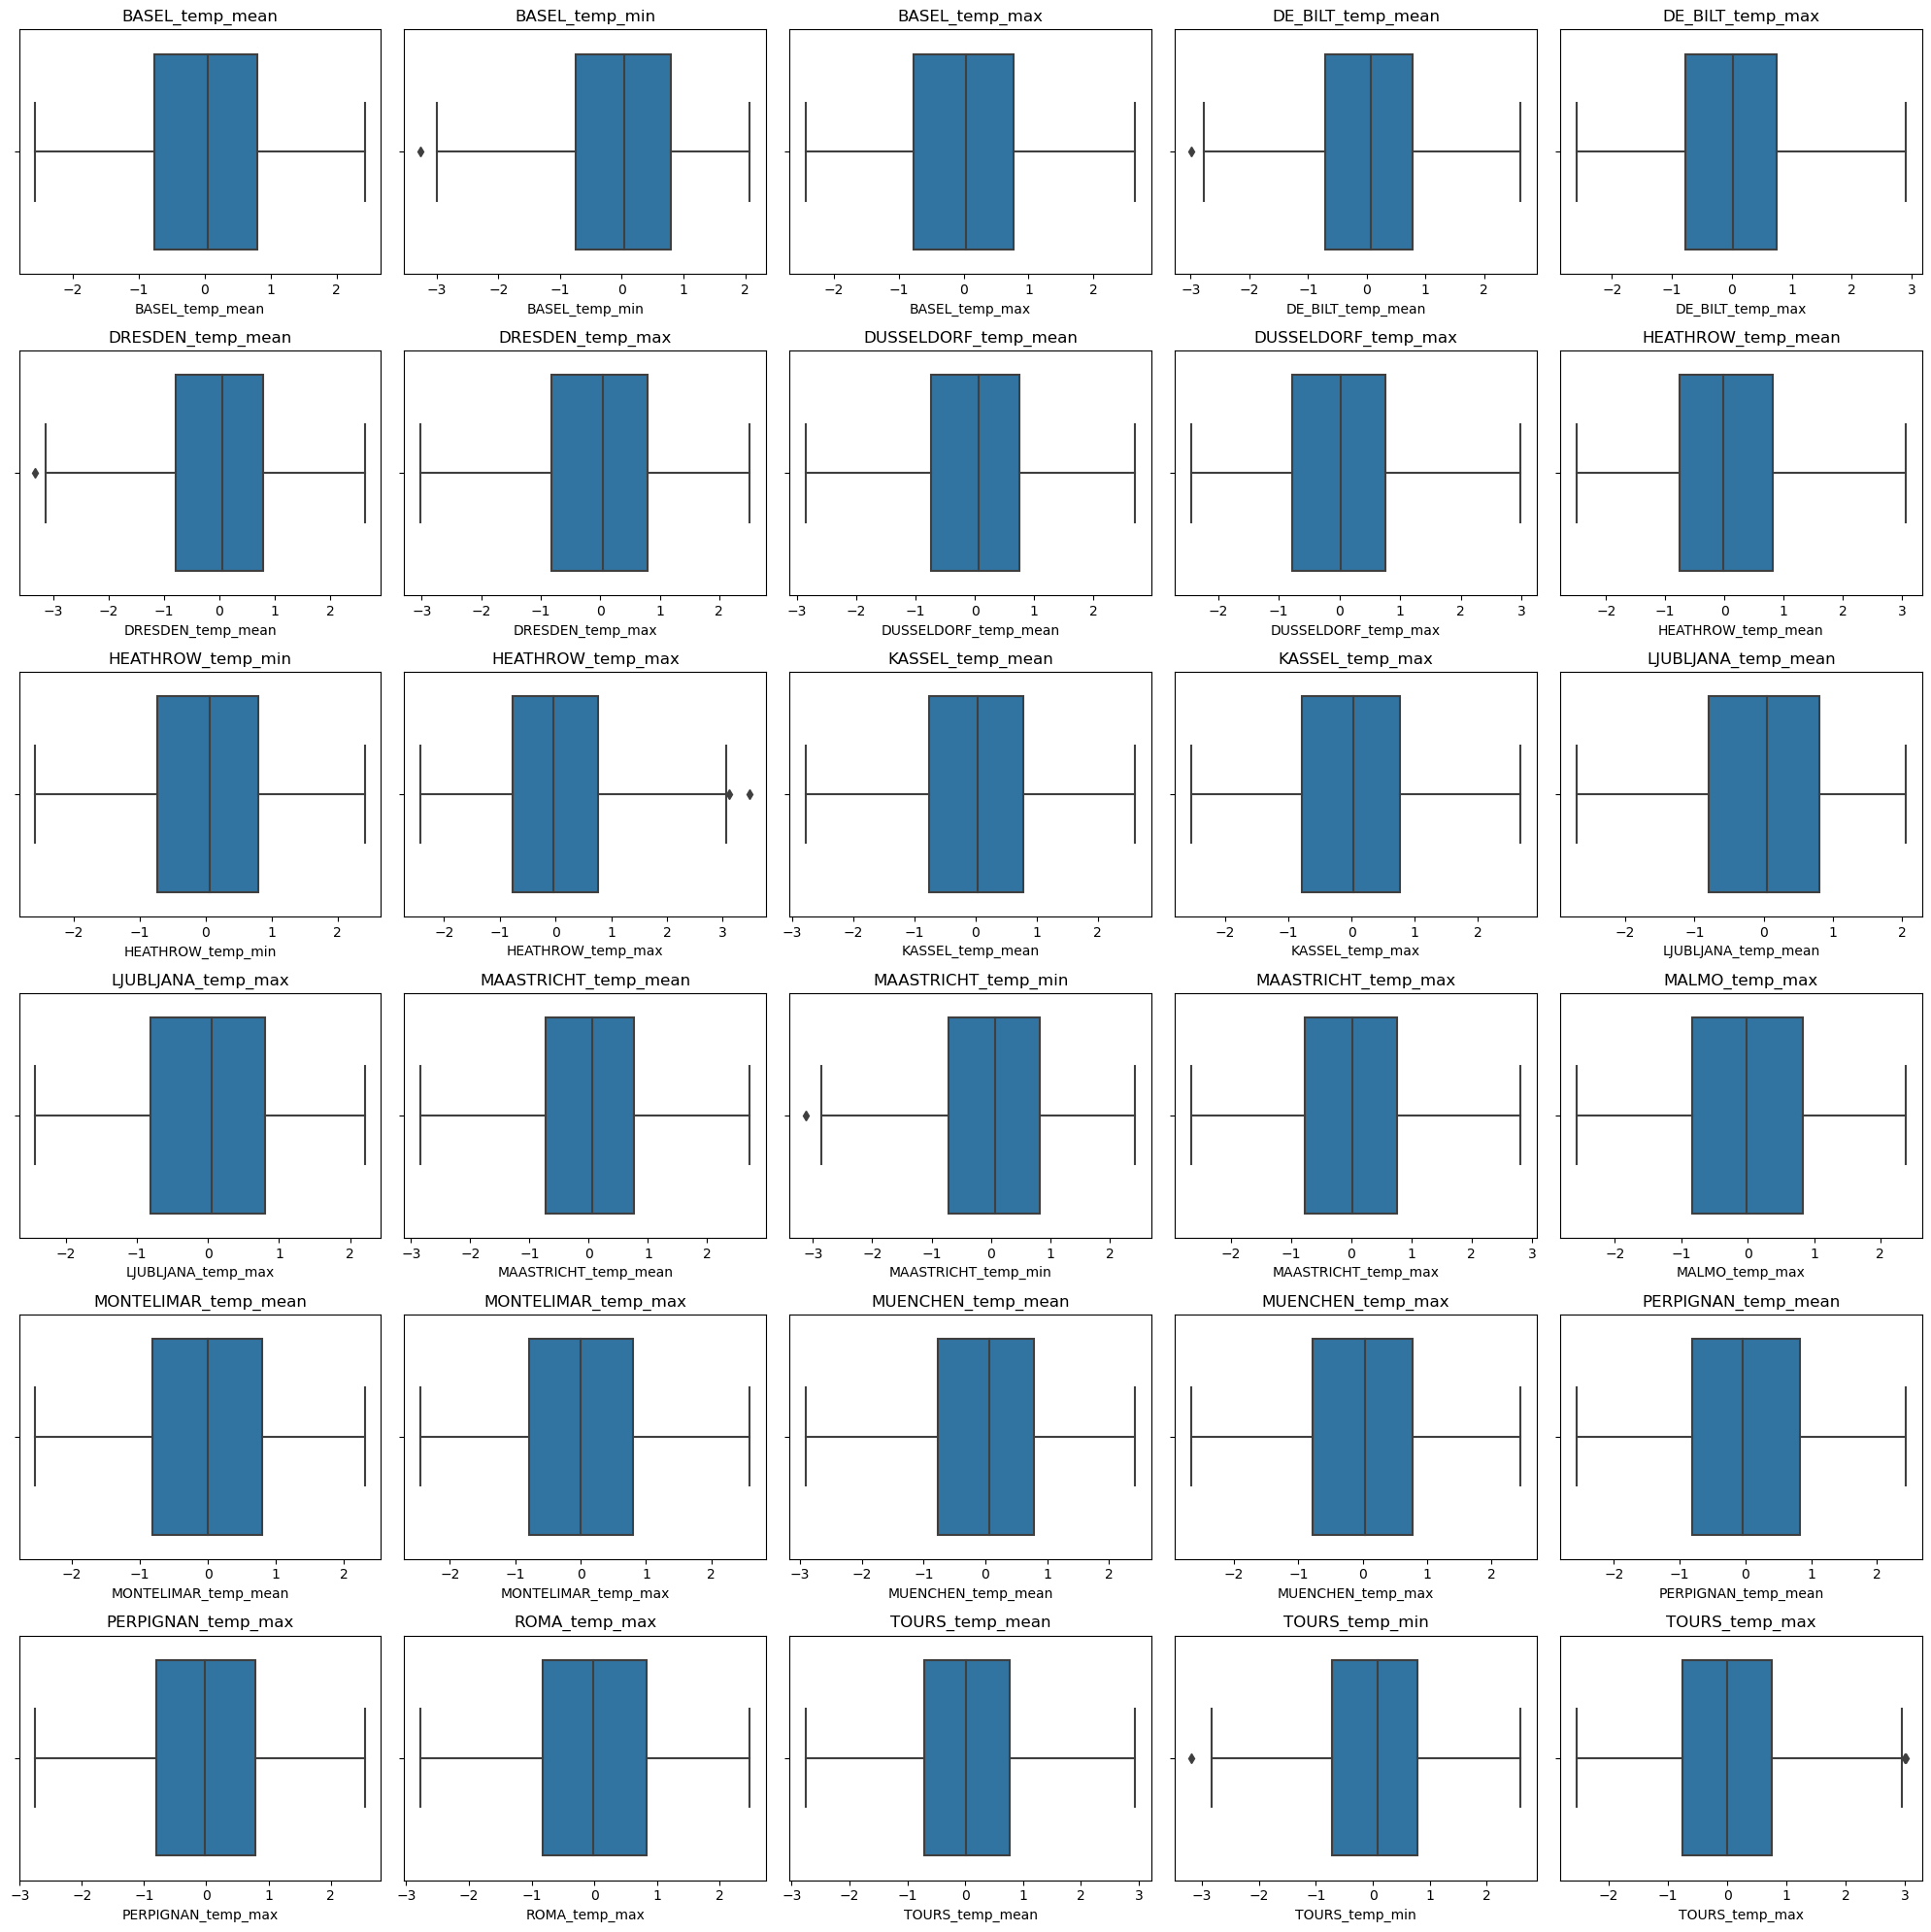

In [ ]:
fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(20, 20))
for i, ax in enumerate(axs.flat):
    if i < len(train.columns):
        sns.boxplot(x=train.iloc[:, i], ax=ax)
        ax.set_title(train.columns[i])
    else:
        ax.set_visible(False)
plt.tight_layout()
plt.show()

##### For Test Data

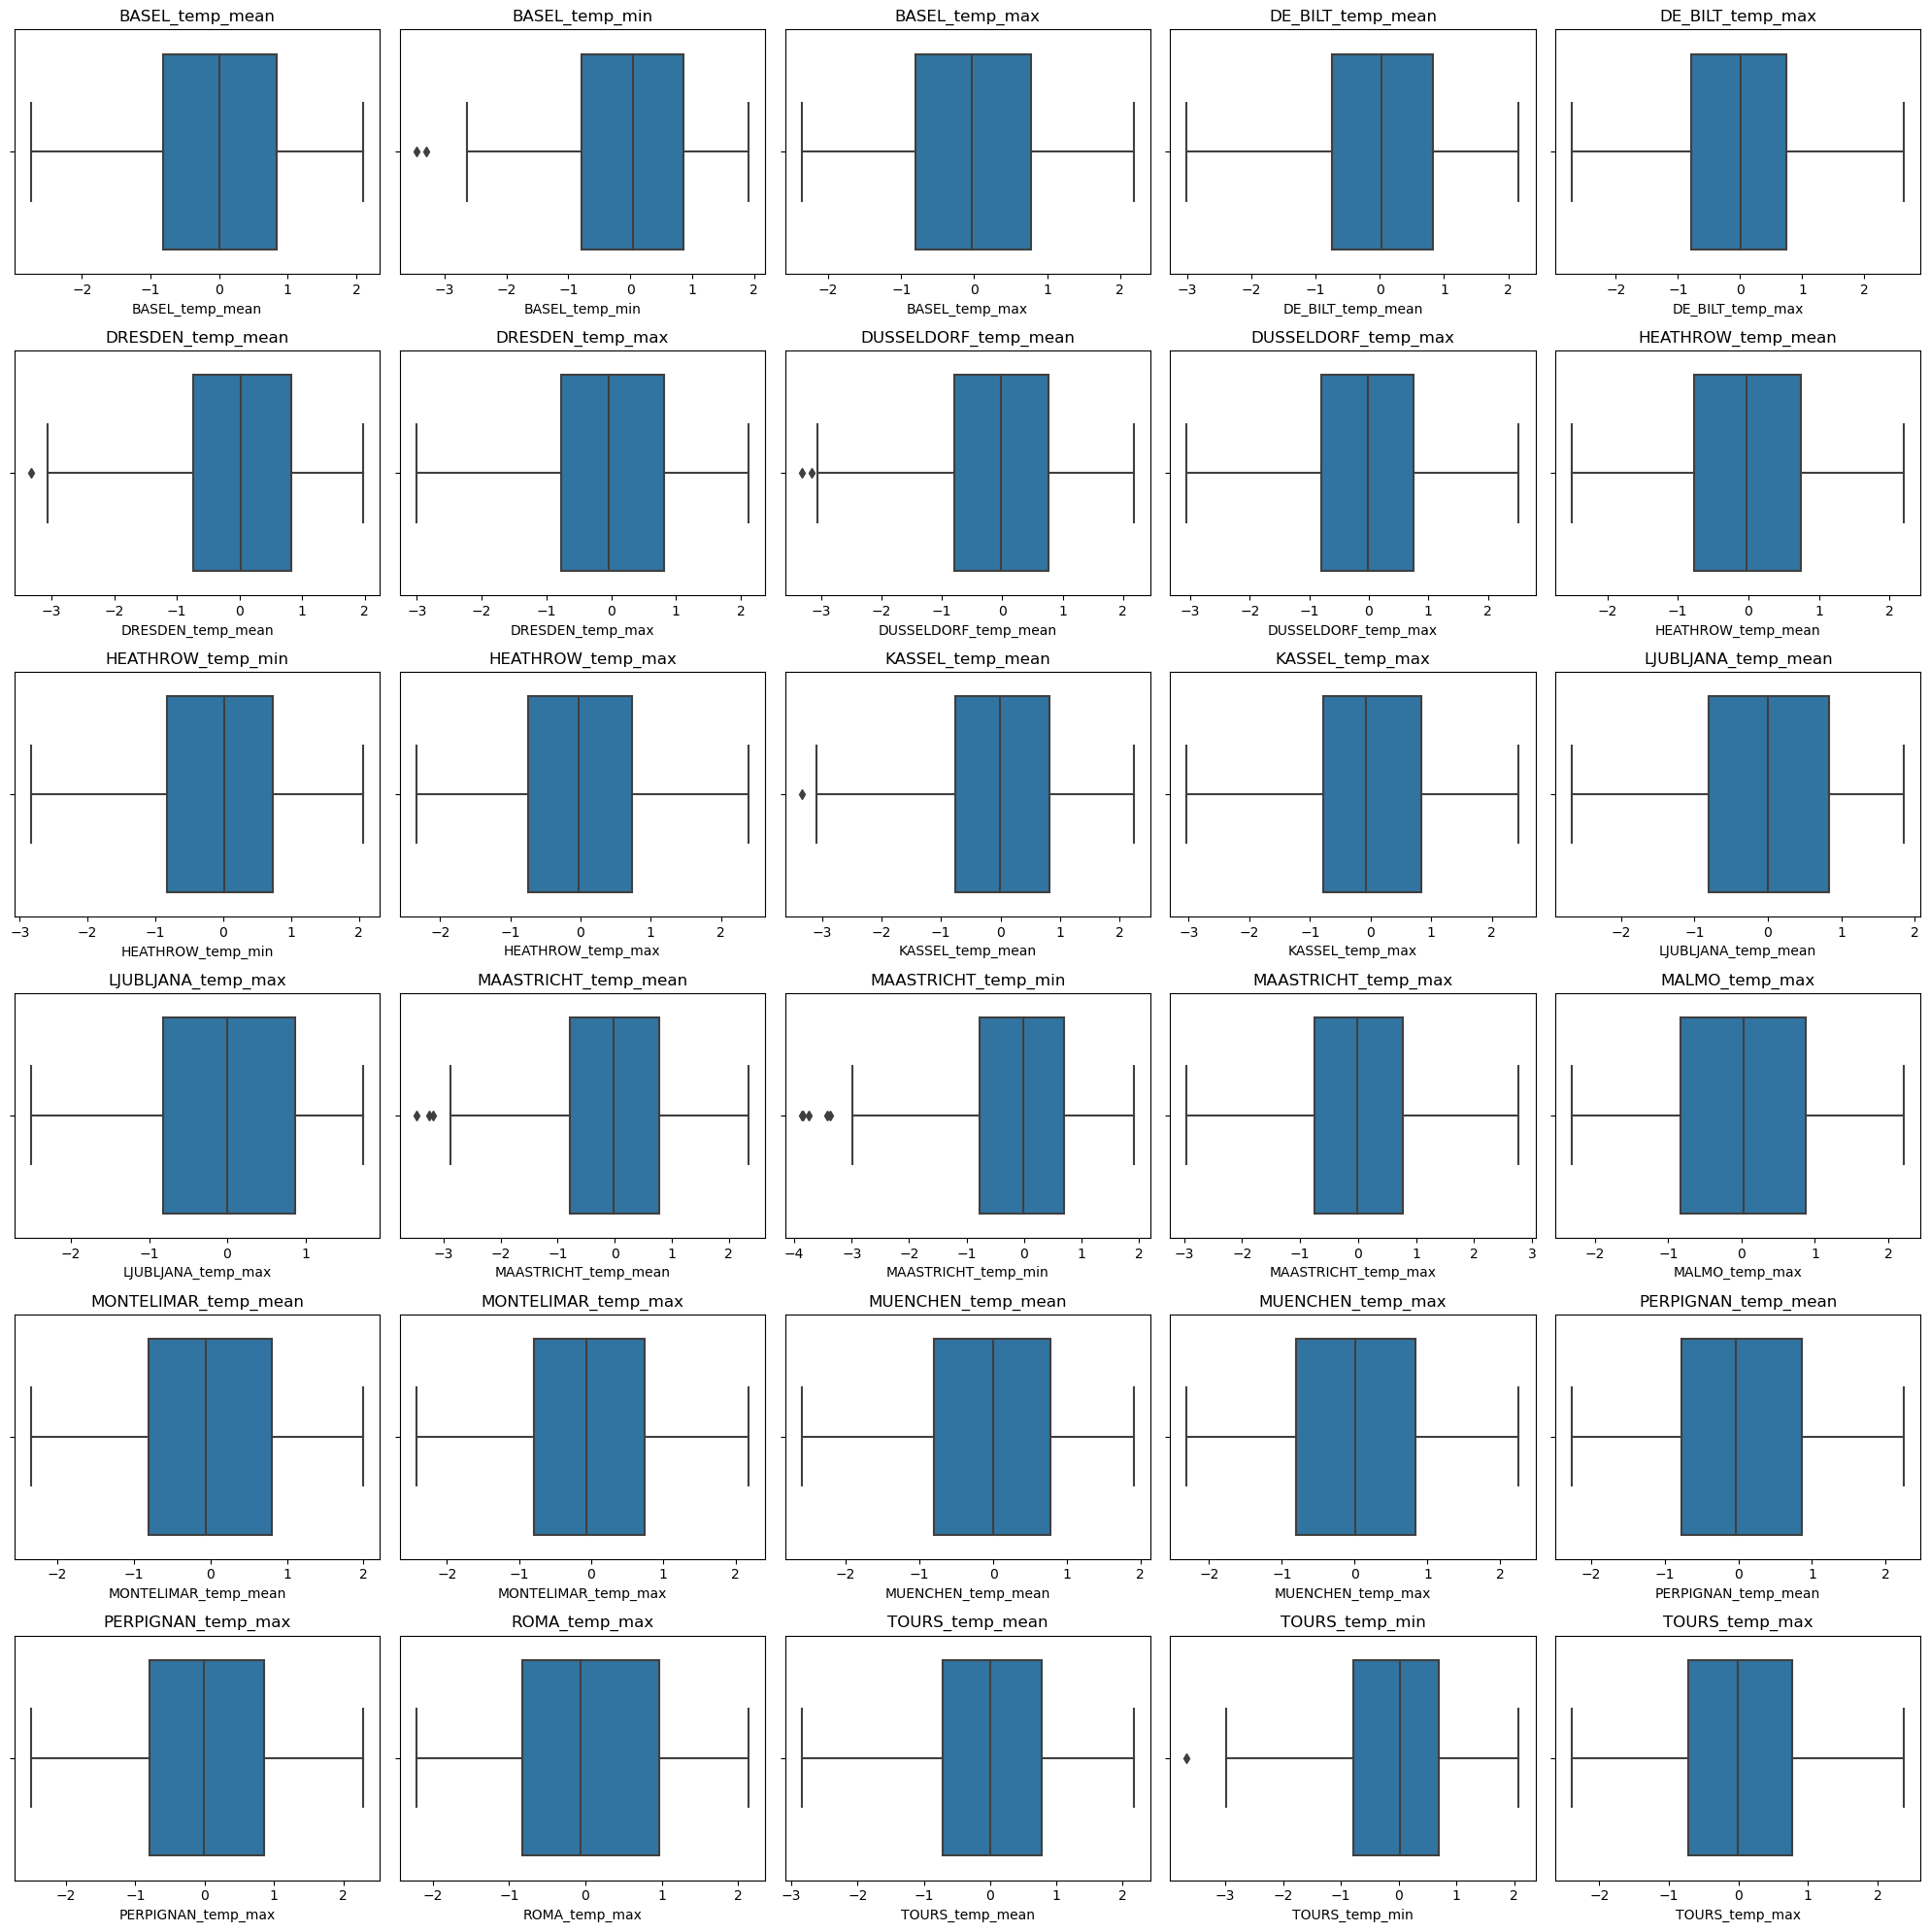

In [ ]:
fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(20, 20))
for i, ax in enumerate(axs.flat):
    if i < len(test.columns):
        sns.boxplot(x=test.iloc[:, i], ax=ax)
        ax.set_title(test.columns[i])
    else:
        ax.set_visible(False)

plt.tight_layout()
plt.show()

## Function to prepare our data for modeling.

In [ ]:
def timeSteps(n,data):
    data = data.values
    X = []
    y = []
    for i in range(len(data) - n):
        X.append(data[i:i+n, :-1])
        y.append(data[i+n, -1])
        
    X = np.array(X)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))
    y=np.array(y)
    return X,y

### Test the funtion

In [ ]:
# Define the window size
n = 7
X_train ,label_train=timeSteps(n,train)
X_test ,label_test=timeSteps(n,test)

In [ ]:
print(X_train.shape ,label_train.shape)
print(X_test.shape ,label_test.shape)

(2915, 7, 29) (2915,)
(725, 7, 29) (725,)


<!---->

# Models

## RNN

In [ ]:
rnn_train_loss_list=[]
rnn_test_loss_list=[]
rnn_early_stopping_list=[]

for timeStep in [7,14,30,45]:
    print("############################# Model With Timesteps: ",timeStep," #############################")
    # Prepare data with timesteps
    X_train ,label_train=timeSteps(timeStep,train)
    X_test ,label_test=timeSteps(timeStep,test)
    
    #Define RNN Arch
    Rnn_model = Sequential()
    Rnn_model.add(SimpleRNN(200, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))
    Rnn_model.add(Dense(units=256, activation='relu'))
    Rnn_model.add(Dense(units=128, activation='relu'))
    Rnn_model.add(Flatten())
    Rnn_model.add(Dense(1, activation='linear'))
    optimizer = Adam(learning_rate=0.0001)
    Rnn_model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    #fit Model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    history = Rnn_model.fit(X_train, label_train, epochs=500,batch_size=64,callbacks=[early_stopping], verbose=True,validation_data=(X_test, label_test))
    stopping_epoch = early_stopping.stopped_epoch
    #Evaluate Model
    train_loss=Rnn_model.evaluate(X_train, label_train, verbose=False)
    test_loss= Rnn_model.evaluate(X_test, label_test, verbose=False)
    rnn_train_loss_list.append(train_loss)
    rnn_test_loss_list.append(test_loss)
    rnn_early_stopping_list.append(stopping_epoch)

############################# Model With Timesteps:  7  #############################
Epoch 1/500
46/46 [==============================] - 1s 8ms/step - loss: 0.2716 - val_loss: 0.1436
Epoch 2/500
46/46 [==============================] - 0s 4ms/step - loss: 0.1510 - val_loss: 0.1322
Epoch 3/500
46/46 [==============================] - 0s 4ms/step - loss: 0.1324 - val_loss: 0.1213
Epoch 4/500
46/46 [==============================] - 0s 4ms/step - loss: 0.1211 - val_loss: 0.1180
Epoch 5/500
46/46 [==============================] - 0s 4ms/step - loss: 0.1129 - val_loss: 0.1135
Epoch 6/500
46/46 [==============================] - 0s 4ms/step - loss: 0.1099 - val_loss: 0.1165
Epoch 7/500
46/46 [==============================] - 0s 5ms/step - loss: 0.1029 - val_loss: 0.1108
Epoch 8/500
46/46 [==============================] - 0s 5ms/step - loss: 0.0998 - val_loss: 0.1210
Epoch 9/500
46/46 [==============================] - 0s 5ms/step - loss: 0.0942 - val_loss: 0.1137
Epoch 10/500
46/46 [===

In [ ]:
Rnn_model.save("RNN_model2.h5")

In [ ]:
stepsize=[7,14,30,45]
print("RNN Models: ")
for i in range(len(stepsize)):
    print("For timestep size: ",stepsize[i])
    print("Training stopped at epoch:", rnn_early_stopping_list[i])
    print("Train loss: {:.4f}".format(rnn_train_loss_list[i]))
    print("Test loss: {:.4f}".format(rnn_test_loss_list[i]),'\n')

RNN Models: 
For timestep size:  7
Training stopped at epoch: 16
Train loss: 0.0731
Test loss: 0.1122 

For timestep size:  14
Training stopped at epoch: 19
Train loss: 0.0567
Test loss: 0.1125 

For timestep size:  30
Training stopped at epoch: 16
Train loss: 0.0617
Test loss: 0.1209 

For timestep size:  45
Training stopped at epoch: 22
Train loss: 0.0513
Test loss: 0.1179 



<!---->

## LSTM

In [ ]:
train_loss_list=[]
test_loss_list=[]
early_stopping_list=[]

for timeStep in [7,14,30,45]:
    print("############################# Model With Timesteps: ",timeStep," #############################")
    # Prepare data with timesteps
    X_train ,label_train=timeSteps(timeStep,train)
    X_test ,label_test=timeSteps(timeStep,test)
    
    #Define Lstm Arch
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=200,activation='tanh',return_sequences=False, input_shape=(X_train.shape[1],X_train.shape[2])))
    lstm_model.add(Dense(units=256, activation='relu'))
    lstm_model.add(Dense(units=128, activation='relu'))
    lstm_model.add(Dense(units=96, activation='relu'))
    lstm_model.add(Dense(units=1, activation='linear'))
    optimizer = Adam(learning_rate=0.0001)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    #fit Model
    early_stopping = EarlyStopping(monitor='val_loss', patience=15)
    history = lstm_model.fit(X_train, label_train, epochs=500,batch_size=64,callbacks=[early_stopping], verbose=True,validation_data=(X_test, label_test))
    stopping_epoch = early_stopping.stopped_epoch
    #Evaluate Model
    train_loss=lstm_model.evaluate(X_train, label_train, verbose=False)
    test_loss= lstm_model.evaluate(X_test, label_test, verbose=False)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    early_stopping_list.append(stopping_epoch)

############################# Model With Timesteps:  7  #############################
Epoch 1/500
46/46 [==============================] - 2s 17ms/step - loss: 0.3811 - val_loss: 0.1723
Epoch 2/500
46/46 [==============================] - 0s 9ms/step - loss: 0.2087 - val_loss: 0.1542
Epoch 3/500
46/46 [==============================] - 0s 10ms/step - loss: 0.1822 - val_loss: 0.1434
Epoch 4/500
46/46 [==============================] - 0s 9ms/step - loss: 0.1603 - val_loss: 0.1328
Epoch 5/500
46/46 [==============================] - 0s 9ms/step - loss: 0.1481 - val_loss: 0.1313
Epoch 6/500
46/46 [==============================] - 0s 10ms/step - loss: 0.1399 - val_loss: 0.1294
Epoch 7/500
46/46 [==============================] - 0s 10ms/step - loss: 0.1323 - val_loss: 0.1309
Epoch 8/500
46/46 [==============================] - 0s 10ms/step - loss: 0.1289 - val_loss: 0.1259
Epoch 9/500
46/46 [==============================] - 0s 10ms/step - loss: 0.1226 - val_loss: 0.1330
Epoch 10/500
46/4

Epoch 20/500
46/46 [==============================] - 1s 17ms/step - loss: 0.1034 - val_loss: 0.1206
Epoch 21/500
46/46 [==============================] - 1s 17ms/step - loss: 0.0995 - val_loss: 0.1211
Epoch 22/500
46/46 [==============================] - 1s 18ms/step - loss: 0.1018 - val_loss: 0.1154
Epoch 23/500
46/46 [==============================] - 1s 17ms/step - loss: 0.0961 - val_loss: 0.1152
Epoch 24/500
46/46 [==============================] - 1s 17ms/step - loss: 0.0944 - val_loss: 0.1138
Epoch 25/500
46/46 [==============================] - 1s 17ms/step - loss: 0.0959 - val_loss: 0.1212
Epoch 26/500
46/46 [==============================] - 1s 18ms/step - loss: 0.0957 - val_loss: 0.1162
Epoch 27/500
46/46 [==============================] - 1s 17ms/step - loss: 0.0941 - val_loss: 0.1167
Epoch 28/500
46/46 [==============================] - 1s 18ms/step - loss: 0.0949 - val_loss: 0.1103
Epoch 29/500
46/46 [==============================] - 1s 17ms/step - loss: 0.0942 - val_los

46/46 [==============================] - 2s 38ms/step - loss: 0.0833 - val_loss: 0.1136
Epoch 46/500
46/46 [==============================] - 2s 38ms/step - loss: 0.0820 - val_loss: 0.1100
Epoch 47/500
46/46 [==============================] - 2s 38ms/step - loss: 0.0836 - val_loss: 0.1209
Epoch 48/500
46/46 [==============================] - 2s 40ms/step - loss: 0.0837 - val_loss: 0.1119
Epoch 49/500
46/46 [==============================] - 2s 40ms/step - loss: 0.0829 - val_loss: 0.1090
Epoch 50/500
46/46 [==============================] - 2s 40ms/step - loss: 0.0790 - val_loss: 0.1212
Epoch 51/500
46/46 [==============================] - 2s 39ms/step - loss: 0.0795 - val_loss: 0.1184
Epoch 52/500
46/46 [==============================] - 2s 39ms/step - loss: 0.0788 - val_loss: 0.1131
Epoch 53/500
46/46 [==============================] - 2s 39ms/step - loss: 0.0785 - val_loss: 0.1088
Epoch 54/500
46/46 [==============================] - 2s 40ms/step - loss: 0.0780 - val_loss: 0.1108
Epo

45/45 [==============================] - 4s 84ms/step - loss: 0.0799 - val_loss: 0.1127
Epoch 58/500
45/45 [==============================] - 4s 82ms/step - loss: 0.0726 - val_loss: 0.1126
Epoch 59/500
45/45 [==============================] - 4s 82ms/step - loss: 0.0763 - val_loss: 0.1120
Epoch 60/500
45/45 [==============================] - 4s 84ms/step - loss: 0.0746 - val_loss: 0.1082
Epoch 61/500
45/45 [==============================] - 4s 82ms/step - loss: 0.0726 - val_loss: 0.1280
Epoch 62/500
45/45 [==============================] - 4s 81ms/step - loss: 0.0727 - val_loss: 0.1095
Epoch 63/500
45/45 [==============================] - 4s 83ms/step - loss: 0.0716 - val_loss: 0.1146
Epoch 64/500
45/45 [==============================] - 4s 88ms/step - loss: 0.0715 - val_loss: 0.1129
Epoch 65/500
45/45 [==============================] - 4s 83ms/step - loss: 0.0696 - val_loss: 0.1187
Epoch 66/500
45/45 [==============================] - 4s 82ms/step - loss: 0.0705 - val_loss: 0.1152
Epo

In [ ]:
lstm_model.save("LSTM_model2.h5")

In [ ]:
stepsize=[7,14,30,45]
print("LSTM Models: ")
for i in range(len(stepsize)):
    print("For timestep size: ",stepsize[i])
    print("Training stopped at epoch:", early_stopping_list[i])
    print("Train loss: {:.4f}".format(train_loss_list[i]))
    print("Test loss: {:.4f}".format(test_loss_list[i]),'\n')

LSTM Models: 
For timestep size:  7
Training stopped at epoch: 60
Train loss: 0.0820
Test loss: 0.1189 

For timestep size:  14
Training stopped at epoch: 54
Train loss: 0.0730
Test loss: 0.1092 

For timestep size:  30
Training stopped at epoch: 67
Train loss: 0.0714
Test loss: 0.1223 

For timestep size:  45
Training stopped at epoch: 74
Train loss: 0.0618
Test loss: 0.1194 



<!---->

## GRU

In [ ]:
Gru_train_loss_list=[]
Gru_test_loss_list=[]
Gru_early_stopping_list=[]

for timeStep in [7,14,30,45]:
    print("############################# Model With Timesteps: ",timeStep," #############################")
    # Prepare data with timesteps
    X_train ,label_train=timeSteps(timeStep,train)
    X_test ,label_test=timeSteps(timeStep,test)
    
    #Define GRU Arch
    model = Sequential()
    model.add(GRU(units=256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(GRU(units=256, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.00005))
    model.summary()
    
    #fit Model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(X_train, label_train, epochs=500,batch_size=16,callbacks=[early_stopping], verbose=True,validation_data=(X_test, label_test))
    stopping_epoch = early_stopping.stopped_epoch
    #Evaluate Model
    train_loss=model.evaluate(X_train, label_train, verbose=False)
    test_loss= model.evaluate(X_test, label_test, verbose=False)
    Gru_train_loss_list.append(train_loss)
    Gru_test_loss_list.append(test_loss)
    Gru_early_stopping_list.append(stopping_epoch)

############################# Model With Timesteps:  7  #############################
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 7, 256)            220416    
                                                                 
 gru_1 (GRU)                 (None, 256)               394752    
                                                                 
 dense_28 (Dense)            (None, 128)               32896     
                                                                 
 dense_29 (Dense)            (None, 64)                8256      
                                                                 
 dense_30 (Dense)            (None, 32)                2080      
                                                                 
 dense_31 (Dense)            (None, 16)                528       
                                  

C:\Users\dell\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


183/183 [==============================] - 6s 17ms/step - loss: 0.2715 - val_loss: 0.1654
Epoch 2/500
183/183 [==============================] - 3s 14ms/step - loss: 0.1725 - val_loss: 0.1433
Epoch 3/500
183/183 [==============================] - 3s 14ms/step - loss: 0.1503 - val_loss: 0.1307
Epoch 4/500
183/183 [==============================] - 3s 14ms/step - loss: 0.1407 - val_loss: 0.1265
Epoch 5/500
183/183 [==============================] - 3s 15ms/step - loss: 0.1302 - val_loss: 0.1258
Epoch 6/500
183/183 [==============================] - 3s 14ms/step - loss: 0.1222 - val_loss: 0.1178
Epoch 7/500
183/183 [==============================] - 3s 14ms/step - loss: 0.1208 - val_loss: 0.1141
Epoch 8/500
183/183 [==============================] - 3s 15ms/step - loss: 0.1122 - val_loss: 0.1126
Epoch 9/500
183/183 [==============================] - 3s 14ms/step - loss: 0.1096 - val_loss: 0.1241
Epoch 10/500
183/183 [==============================] - 3s 15ms/step - loss: 0.1087 - val_loss

Epoch 32/500
182/182 [==============================] - 4s 24ms/step - loss: 0.0892 - val_loss: 0.1061
Epoch 33/500
182/182 [==============================] - 4s 24ms/step - loss: 0.0877 - val_loss: 0.1059
Epoch 34/500
182/182 [==============================] - 4s 24ms/step - loss: 0.0877 - val_loss: 0.1035
Epoch 35/500
182/182 [==============================] - 4s 24ms/step - loss: 0.0859 - val_loss: 0.1030
Epoch 36/500
182/182 [==============================] - 5s 25ms/step - loss: 0.0861 - val_loss: 0.1059
Epoch 37/500
182/182 [==============================] - 4s 25ms/step - loss: 0.0855 - val_loss: 0.1044
Epoch 38/500
182/182 [==============================] - 4s 24ms/step - loss: 0.0857 - val_loss: 0.1088
Epoch 39/500
182/182 [==============================] - 4s 24ms/step - loss: 0.0846 - val_loss: 0.1023
Epoch 40/500
182/182 [==============================] - 4s 24ms/step - loss: 0.0832 - val_loss: 0.1046
Epoch 41/500
182/182 [==============================] - 4s 24ms/step - lo

181/181 [==============================] - 10s 53ms/step - loss: 0.0887 - val_loss: 0.1045
Epoch 44/500
181/181 [==============================] - 10s 53ms/step - loss: 0.0855 - val_loss: 0.1043
Epoch 45/500
181/181 [==============================] - 10s 54ms/step - loss: 0.0845 - val_loss: 0.1043
Epoch 46/500
181/181 [==============================] - 10s 55ms/step - loss: 0.0846 - val_loss: 0.1049
Epoch 47/500
181/181 [==============================] - 10s 53ms/step - loss: 0.0844 - val_loss: 0.1067
Epoch 48/500
181/181 [==============================] - 10s 54ms/step - loss: 0.0846 - val_loss: 0.1079
Epoch 49/500
181/181 [==============================] - 10s 53ms/step - loss: 0.0838 - val_loss: 0.1074
Epoch 50/500
181/181 [==============================] - 10s 53ms/step - loss: 0.0829 - val_loss: 0.1068
Epoch 51/500
181/181 [==============================] - 9s 52ms/step - loss: 0.0839 - val_loss: 0.1065
############################# Model With Timesteps:  45  #####################

In [ ]:
model.save("GRU_model2.h5")

In [ ]:
stepsize=[7,14,30,45]
print("GRU Models: ")
for i in range(len(stepsize)):
    print("For timestep size: ",stepsize[i])
    print("Training stopped at epoch:", Gru_early_stopping_list[i])
    print("Train loss: {:.4f}".format(Gru_train_loss_list[i]))
    print("Test loss: {:.4f}".format(Gru_test_loss_list[i]),'\n')

GRU Models: 
For timestep size:  7
Training stopped at epoch: 34
Train loss: 0.0798
Test loss: 0.1051 

For timestep size:  14
Training stopped at epoch: 53
Train loss: 0.0728
Test loss: 0.1046 

For timestep size:  30
Training stopped at epoch: 50
Train loss: 0.0802
Test loss: 0.1065 

For timestep size:  45
Training stopped at epoch: 35
Train loss: 0.0889
Test loss: 0.1100 



<!---->

# Models Results

In [ ]:
data="""
|StepSize|# of epochs (early stopping effect) For RNN |RNN Training loss|RNN Validation loss|# of epochs (early stopping effect) For LSTM|LSTM Training loss|LSTM Validation loss|# of epochs (early stopping effect) For GRU|GRU Training loss|GRU Validation loss|
|7|16 out of 500|0.0731|0.1122|60 out of 500|0.0820|0.1189|34 out of 500|0.0798|0.1051|
|14|19 out of 500|0.0567|0.1125|54 out of 500|0.0730|0.1092 |53 out of 500|0.0728|0.1046|
|30|16 out of 500|0.0617|0.1209|67 out of 500|0.0714|0.1223|50 out of 500|0.0802|0.1065|
|45|22 out of 500|0.0513|0.1179|74 out of 500|0.0618|0.1194 |35 out of 500|0.0889|0.1100|
"""

In [ ]:
import io
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: red' if v else '' for v in is_min]

df = pd.read_table(io.StringIO(data), sep='|', header=0, index_col=1, decimal='.')
df = df.drop(['Unnamed: 0', 'Unnamed: 11'], axis=1)
df.style.apply(highlight_min, subset=['RNN Validation loss', 'LSTM Validation loss', 'GRU Validation loss'])

,# of epochs (early stopping effect) For RNN,RNN Training loss,RNN Validation loss,# of epochs (early stopping effect) For LSTM,LSTM Training loss,LSTM Validation loss,# of epochs (early stopping effect) For GRU,GRU Training loss,GRU Validation loss
StepSize,,,,,,,,,
7,16 out of 500,0.073100,0.112200,60 out of 500,0.082000,0.118900,34 out of 500,0.079800,0.105100
14,19 out of 500,0.056700,0.112500,54 out of 500,0.073000,0.109200,53 out of 500,0.072800,0.104600
30,16 out of 500,0.061700,0.120900,67 out of 500,0.071400,0.122300,50 out of 500,0.080200,0.106500
45,22 out of 500,0.051300,0.117900,74 out of 500,0.061800,0.119400,35 out of 500,0.088900,0.110000


<!---->

# Conclusion

### *RNN:*

- The RNN model had the lowest validation loss for step sizes of 7 and 14, with a training loss of 0.07310 and 0.056700 respectively, and a validation loss of 0.112200 and 0.112500 respectively.

- The number of epochs required for early stopping ranged from 16 to 22. The model stopped training after 16 epochs for a step size of 7 and after 19 epochs for a step size of 14.

- Based on these results, the RNN model performed best for intermediate step sizes, with a step size of 7 being the most effective. The RNN model had **the best validation loss of 0.112200 for a step size of 7.**

### *LSTM:*

- The LSTM model had the lowest validation loss for step sizes of 14 and 7, with a training loss of 0.073000 and 0.082000 respectively, and a validation loss of 0.109200 and 0.118900 respectively.

- The number of epochs required for early stopping ranged from 54 to 74. The model stopped training after 54 epochs for a step size of 14 and after 60 epochs for a step size of 7.

- Based on these results, the LSTM model performed best for small and large step sizes, with a step size of 14 being the most effective. The LSTM model had **the best validation loss of 0.109200 for a step size of 14.**

### *GRU:*

- The GRU model had the lowest validation loss for step sizes of 14 and 7, with a training loss of 0.072800 and 0.079800 respectively, and a validation loss of 0.104600 and 0.105100 respectively.

- The number of epochs required for early stopping ranged from 34 to 53. The model stopped training after 53 epochs for a step size of 14 and after 34 epochs for a step size of 7.

- Based on these results, the GRU model performed best for intermediate step sizes, with a step size of 14 being the most effective. The GRU model had **the best validation loss of 0.104600 for a step size of 14.**

**When it comes to batch size, our experiments have shown that decreasing the batch size can result in better performance for our models. Specifically, we found that RNN with a batch size of 64, LSTM with a batch size of 64, and GRU with a batch size of 16 all performed well. for these models, smaller batch sizes can lead to better results.**

**Overall, based on our experiments, the best model was the GRU model with a step size of 14 and a validation loss of 0.104600.**